# Metrics validation for UnetAtt models trained on different datasets

In [1]:
import sys
sys.path.append('..')

from functools import reduce

import pandas as pd

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex #, seismic_plot

from utils import get_cv, draw_modifications_dist, get_modifications_list, validate_all

In [2]:
base_path = '/notebooks/egor/geolog/notebooks/processed/'  # /notebooks/tonya/gpn_metrics_study/SeismicPro/metrics_study/unet_att_results/models_output

# Test on Dataset 1

In [3]:
paths = {
    'lift': '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy',
    'raw': '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy',
    'm_1': base_path + 'ds1_ds1.sgy',
    'm_2': base_path + 'ds2_ds1.sgy',
    'm_3': base_path + 'ds3_ds1.sgy',
}

scale_lift = 1

### Build Index

In [4]:
%%time

field_index = reduce(lambda x, y: x.merge(y), 
                     (FieldIndex(name=name, path=path, extra_headers=['offset']) for name, path in paths.items()))
print("Fields in data: %d" % len(field_index))

Fields in data: 51
CPU times: user 1.38 s, sys: 996 ms, total: 2.38 s
Wall time: 2.38 s


In [5]:
%%time

batch = (Dataset(field_index, SeismicBatch)
         .next_batch(len(field_index))
         .load(fmt='segy', components=tuple(paths.keys())))

../seismicpro/batchflow/batchflow/batch.py:297: UserWarning: All batch data is erased
  warnings.warn("All batch data is erased")


CPU times: user 43.5 s, sys: 38.8 s, total: 1min 22s
Wall time: 1min 35s


## Calculate metrics

In [6]:
%%time

res = validate_all(batch, scale_lift=scale_lift)
df = pd.DataFrame(res)
df.to_csv('unet_att_results/test_d1.csv')

CPU times: user 12.1 s, sys: 8.85 s, total: 21 s
Wall time: 21 s


In [7]:
df.head()

,LIFT,M_1,M_2,M_3,RAW
0,0.0,0.371800,0.569269,0.509314,1.225579
1,0.0,1.360453,1.360453,1.360453,1.360453
2,0.0,0.888706,0.888706,0.888706,0.888706
3,0.0,0.246082,0.246082,0.246082,0.246082
4,0.0,0.390008,0.803365,0.644757,2.737518


In [8]:
df.to_csv('unet_att_results/test_d1.csv')

# Test on Dataset 2

In [9]:
paths = {
    'lift': '/data/NA/noise_dataset_2/D02_Lift_SP.sgy',
    'raw': '/data/NA/noise_dataset_2/D01_for_Lift.sgy',
    'm_1': base_path + 'ds1_ds2.sgy',
    'm_2': base_path + 'ds2_ds2.sgy',
    'm_3': base_path + 'ds3_ds2.sgy',
}

scale_lift = 2.3182

### Build Index

In [10]:
%%time

field_index = reduce(lambda x, y: x.merge(y), 
                     (FieldIndex(name=name, path=path, extra_headers=['offset']) for name, path in paths.items()))
print("Fields in data: %d" % len(field_index))

Fields in data: 91
CPU times: user 764 ms, sys: 484 ms, total: 1.25 s
Wall time: 1.24 s


In [11]:
%%time

batch = (Dataset(field_index, SeismicBatch)
         .next_batch(len(field_index))
         .load(fmt='segy', components=tuple(paths.keys())))

CPU times: user 14.4 s, sys: 11.9 s, total: 26.3 s
Wall time: 27.1 s


## Calculate metrics

In [12]:
%%time

res = validate_all(batch, scale_lift=scale_lift)
df = pd.DataFrame(res)

df.to_csv('unet_att_results/test_d2.csv')

CPU times: user 4.04 s, sys: 276 ms, total: 4.32 s
Wall time: 4.32 s


# Test on Dataset 3

In [13]:
paths = {
    'lift': '/notebooks/egor/noise_dataset_3/5_NA-gr_output_lift5.sgy',
    'raw': '/notebooks/egor/noise_dataset_3/5_NA-gr_input_raw.sgy',
    'm_1': base_path + 'ds1_ds3.sgy',
    'm_2': base_path + 'ds2_ds3.sgy',
    'm_3': base_path + 'ds3_ds3.sgy',
}

scale_lift = 0.000558

### Build Index

In [14]:
%%time

field_index = reduce(lambda x, y: x.merge(y), 
                     (FieldIndex(name=name, path=path, extra_headers=['offset']) for name, path in paths.items()))
print("Fields in data: %d" % len(field_index))

Fields in data: 201
CPU times: user 8.49 s, sys: 18.4 s, total: 26.9 s
Wall time: 1min 26s


In [15]:
%%time

batch = (Dataset(field_index, SeismicBatch)
         .next_batch(len(field_index))
         .load(fmt='segy', components=tuple(paths.keys())))

CPU times: user 3min 10s, sys: 3min, total: 6min 10s
Wall time: 7min 40s


## Calculate metrics

In [16]:
%%time

res = validate_all(batch, scale_lift=scale_lift)
df = pd.DataFrame(res)

df.to_csv('unet_att_results/test_d3.csv')

CPU times: user 55.9 s, sys: 16.3 s, total: 1min 12s
Wall time: 1min 12s


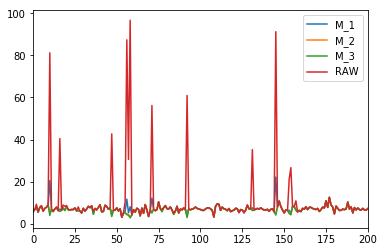

In [17]:
df[['M_1', 'M_2', 'M_3', 'RAW']].plot()

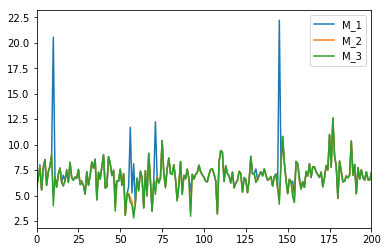

In [19]:
df[['M_1', 'M_2', 'M_3']].plot()